In [1]:
%load_ext autoreload

In [4]:
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mintpy
from osgeo import gdal
from mintpy.utils import plot as pp
from mintpy.utils import readfile, utils as ut, plot as pp
import h5py
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mintpy import view
from mintpy.objects import timeseries
from operator import itemgetter 
import datetime
from datetime import timedelta
from scipy import interpolate
import matplotlib.dates as mdates
from miaplpy.objects.invert_pixel import process_pixel 
from scipy import stats
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
font = {'family' : 'DejaVu Sans',
        'size'   : 15}

In [5]:
project_dir = './../DATA/Miami_data'
out_dir = './out_figures'
#os.chdir(project_dir)

out_amplitude = project_dir + '/mean_amplitude'


reflat = 25.8791
reflon = -80.1259

In [6]:
def get_data_ps(ymin, ymax, xmin, xmax, out_amplitude, shift=0):

    vel_file = project_dir + '/velocity.h5'
    geo_file = project_dir + '/org_geometry/geometryRadar.h5'
    mask_file_t = project_dir + '/maskTempCoh.h5'
    mask_file_ps = project_dir + '/maskPS.h5'
    mask_file_w = project_dir + '/waterMask.h5'
    amp_dips_indx_file = project_dir + '/amp_dipersion_index'
    top_eigenvalues_file = project_dir + '/top_eigenvalues'
    shp_file = project_dir + '/phase_series.h5'

    
    amd_memmap = gdal.Open(amp_dips_indx_file + '.vrt', gdal.GA_ReadOnly)
    Amp_dips_indx = np.flipud(amd_memmap.GetRasterBand(1).ReadAsArray()[ymin:ymax, xmin:xmax]) # , xmax-xmin, ymax-ymin))
    
    with h5py.File(shp_file, 'r') as ds:
        shp = np.flipud(ds['shp'][ymin:ymax, xmin:xmax])
        

    top_memmap = gdal.Open(top_eigenvalues_file + '.vrt', gdal.GA_ReadOnly)
    Top_eigenvalues = np.flipud(top_memmap.GetRasterBand(1).ReadAsArray()[ymin:ymax, xmin:xmax]) # , xmax-xmin, ymax-ymin))
    Top_eigenvalues_percent = np.flipud(top_memmap.GetRasterBand(3).ReadAsArray()[ymin:ymax, xmin:xmax])
    
    mask_t = np.flipud(readfile.read(mask_file_t, datasetName='mask')[0][ymin:ymax, xmin:xmax])
    mask_p = np.flipud(readfile.read(mask_file_ps, datasetName='mask')[0][ymin:ymax, xmin:xmax])
    mask_w = np.flipud(readfile.read(mask_file_w, datasetName='mask')[0][ymin:ymax, xmin:xmax])
    
    mask = shp < 10

    DEM = np.flipud(readfile.read(geo_file, datasetName='height')[0][ymin:ymax, xmin:xmax]) + shift


    velocity = np.flipud(readfile.read(vel_file, datasetName='velocity')[0][ymin:ymax, xmin:xmax])
  
    am_memmap = gdal.Open(out_amplitude + '.vrt', gdal.GA_ReadOnly)
    amplitude = np.flipud(am_memmap.GetRasterBand(1).ReadAsArray()[ymin:ymax, xmin:xmax]) # , xmax-xmin, ymax-ymin))

    velocity[mask_w==0] = np.nan
 
    DEM[mask_w==0] = np.nan

    Amp_dips_indx[mask_w==0] = np.nan
    Top_eigenvalues[mask_w==0] = np.nan
    Top_eigenvalues_percent[mask_w==0] = np.nan
     
    vel = velocity[mask==1]*1000

    amp_dips_indx = Amp_dips_indx[mask==1]
    top_eigenvalues = Top_eigenvalues[mask==1]
    top_eigenvalues_percent = Top_eigenvalues_percent[mask==1]
    
    
    x = np.linspace(0, velocity.shape[1]-1, velocity.shape[1])
    y = np.linspace(0, velocity.shape[0]-1, velocity.shape[0])
    x, y = np.meshgrid(x, y)

    xv = x[mask==1]
    yv = y[mask==1]
    
    return amplitude, xv, yv, vel, DEM, amp_dips_indx, top_eigenvalues, top_eigenvalues_percent, shp


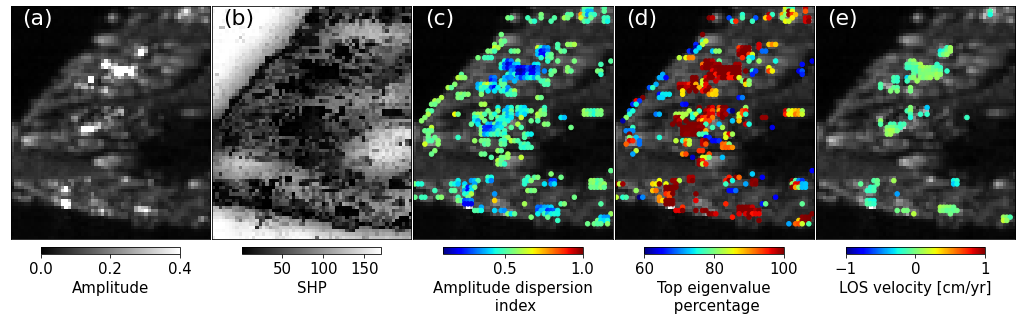

In [7]:
plt.rcParams["font.size"] = "15"

amplitude, xv, yv, vel, dem, amp_dips_indx, top_eigenvalues, top_eigenvalues_percent, shp  = get_data_ps(310, 380, 900, 960, out_amplitude, 26)
amplitude = (amplitude - np.nanmin(amplitude))/(np.nanmax(amplitude) - np.nanmin(amplitude))

mask = (amp_dips_indx<0.42) *(top_eigenvalues_percent>95)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(18, 8))

ax = axs[4]
ax.imshow(amplitude, cmap='gray', vmin=0, vmax=0.4)
im = ax.scatter(xv[mask], yv[mask], c=vel[mask]/10, s=20, cmap='jet', vmin=-1, vmax=1); 
cbar = plt.colorbar(im, ax=ax, shrink=0.7, orientation='horizontal', pad=0.02)

cbar.set_label('LOS velocity [cm/yr]')

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.text(3,5, '(e)', color='w', fontsize=22)


mask = (amp_dips_indx<0.4) #*(top_eigenvalues_percent>90)

ax = axs[0]
im = ax.imshow(amplitude, cmap='gray', vmin=0, vmax=0.4)
#im = ax.scatter(xv[mask], yv[mask], c=vel[mask], s=10, cmap='jet', vmin=-15, vmax=15); 
cbar = plt.colorbar(im, ax=ax, shrink=0.7, orientation='horizontal', pad=0.02)

cbar.set_label('Amplitude')

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.text(3,5, '(a)', color='w', fontsize=22)



ax = axs[2]
ax.imshow(amplitude, cmap='gray', vmin=0, vmax=0.4)
im = ax.scatter(xv, yv, c=amp_dips_indx, s=20, cmap='jet', vmin=0.1, vmax=1); 
cbar = plt.colorbar(im, ax=ax, shrink=0.7, orientation='horizontal', pad=0.02)

cbar.set_label('Amplitude dispersion\n index')

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.text(3,5, '(c)', color='w', fontsize=22)


ax = axs[3]
ax.imshow(amplitude, cmap='gray', vmin=0, vmax=0.4)
im = ax.scatter(xv, yv, c=top_eigenvalues_percent, s=20, cmap='jet', vmin=60, vmax=100); 
cbar = plt.colorbar(im, ax=ax, shrink=0.7, orientation='horizontal', pad=0.02)

cbar.set_label('Top eigenvalue\n percentage')

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.text(3,5, '(d)', color='w', fontsize=22)


ax = axs[1]
im = ax.imshow(shp, cmap='gray')
#im = ax.scatter(xv[mask], yv[mask], c=vel[mask], s=10, cmap='jet', vmin=-15, vmax=15); 
cbar = plt.colorbar(im, ax=ax, shrink=0.7, orientation='horizontal', pad=0.02)

cbar.set_label('SHP')

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.text(3,5, '(b)', color='k', fontsize=22)


fig.subplots_adjust(hspace=0, wspace=0.01)

#plt.savefig(out_dir +'/ps_analysis_different_criteria.png', bbox_inches='tight', dpi=300) 

